# **Step 1: Install and Import Libraries**

In [ ]:
!pip install yfinance pandas numpy matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Core
import time

# Sklearn
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier



# **Step 2: Download Historical Data**

Download daily S&P 500 data from Yahoo Finance (2010–2024):

In [ ]:
# Download S&P 500 (^GSPC) data
data = yf.download('^GSPC', start='2010-01-01', end='2024-12-31')

# Display the first few rows
print(data.head())


/tmp/ipython-input-1024837413.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^GSPC', start='2010-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000


In [ ]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [ ]:
data.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2010-01-04 to 2024-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   3773 non-null   float64
 1   (High, ^GSPC)    3773 non-null   float64
 2   (Low, ^GSPC)     3773 non-null   float64
 3   (Open, ^GSPC)    3773 non-null   float64
 4   (Volume, ^GSPC)  3773 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.9 KB


In [ ]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
count,3773.000000,3773.000000,3773.000000,3773.000000,3.773000e+03
mean,2727.439112,2741.379794,2711.377890,2726.890928,3.938928e+09
std,1264.115621,1270.407956,1257.309511,1264.040211,9.514030e+08
min,1022.580017,1032.949951,1010.909973,1027.650024,0.000000e+00
25%,1701.839966,1707.630005,1693.290039,1699.859985,3.374490e+09
50%,2431.770020,2441.399902,2419.969971,2431.919922,3.784360e+09
75%,3818.800049,3843.669922,3789.540039,3816.219971,4.301060e+09
max,6090.270020,6099.970215,6079.979980,6089.029785,1.061781e+10


In [ ]:
data.to_csv('sp500_data.csv')

# **Step 3: Feature Engineering**

Create log returns, rolling averages, and the target (volatility).

In [ ]:
# Calculate daily log returns
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

# Rolling statistics
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['Volume_MA_5'] = data['Volume'].rolling(window=5).mean()

# Realized volatility as target (standard deviation of log returns over 10 days)
data['RealizedVolatility'] = data['LogReturn'].rolling(window=10).std()

# Drop missing rows
data = data.dropna()

data.head()

Price,Close,High,Low,Open,Volume,LogReturn,MA_5,MA_20,Volume_MA_5,RealizedVolatility
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,
Date,,,,,,,,,,
2010-02-01,1089.189941,1089.380005,1073.890015,1073.890015,4077610000,0.014165,1087.452002,1121.862000,4.998778e+09,0.012735
2010-02-02,1103.319946,1104.729980,1087.959961,1090.050049,4749540000,0.012890,1089.681982,1120.378497,5.002304e+09,0.012804
2010-02-03,1097.280029,1102.719971,1093.969971,1100.670044,4285450000,-0.005489,1089.637988,1118.416498,4.795570e+09,0.012616
2010-02-04,1063.109985,1097.250000,1062.780029,1097.250000,5859690000,-0.031636,1085.353979,1114.714996,4.877028e+09,0.014759
2010-02-05,1066.189941,1067.130005,1044.500000,1064.119995,6438900000,0.002893,1083.817969,1110.939996,5.082238e+09,0.013546


# **Step 4: Define Regression Features and Target**

Now that you have engineered features, define:

X (independent variables) → predictors

y (dependent variable) → realized volatility

In [ ]:
# Feature columns
features = ['LogReturn', 'MA_5', 'MA_20', 'Volume', 'Volume_MA_5']

# Target variable
target = 'RealizedVolatility'

X = data[features]
y = data[target]

print(X.shape, y.shape)


(3754, 5) (3754,)


# **EDA**

## **Visualize Volatility**

To understand the regression target visually:

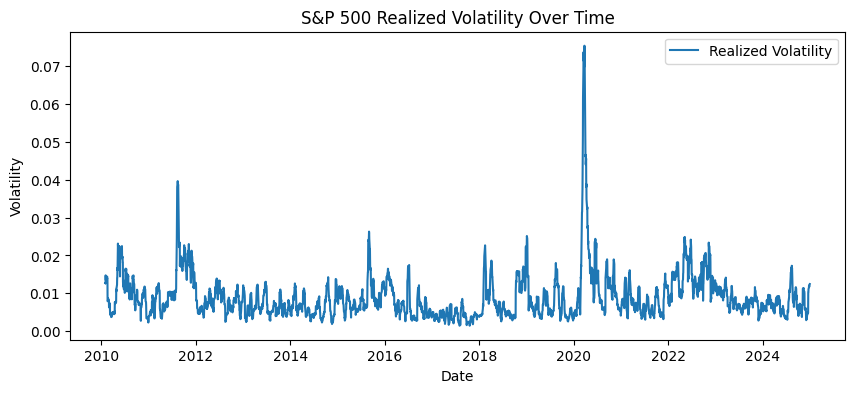

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(data.index, data['RealizedVolatility'], label='Realized Volatility')
plt.title('S&P 500 Realized Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## **Log Returns Analysis**

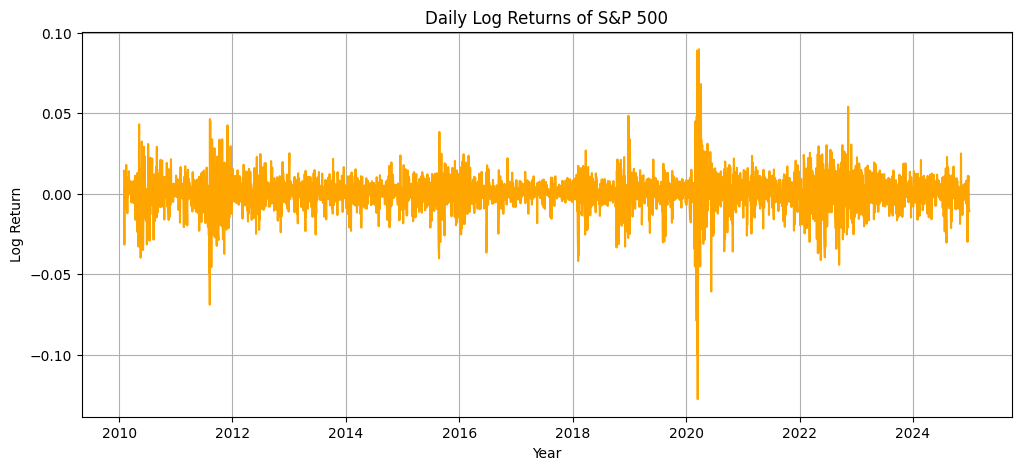

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['LogReturn'], color='orange')
plt.title('Daily Log Returns of S&P 500')
plt.xlabel('Year')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()


## **Distribution of Log Returns**

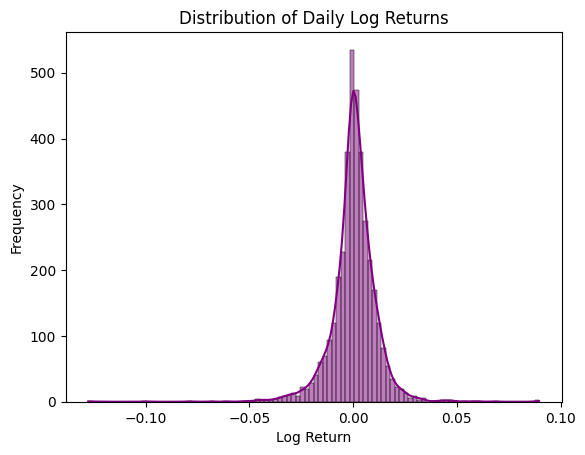

In [ ]:
import seaborn as sns

sns.histplot(data['LogReturn'], bins=100, kde=True, color='purple')
plt.title('Distribution of Daily Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()


## **Volatility (Target Variable) Over Time**

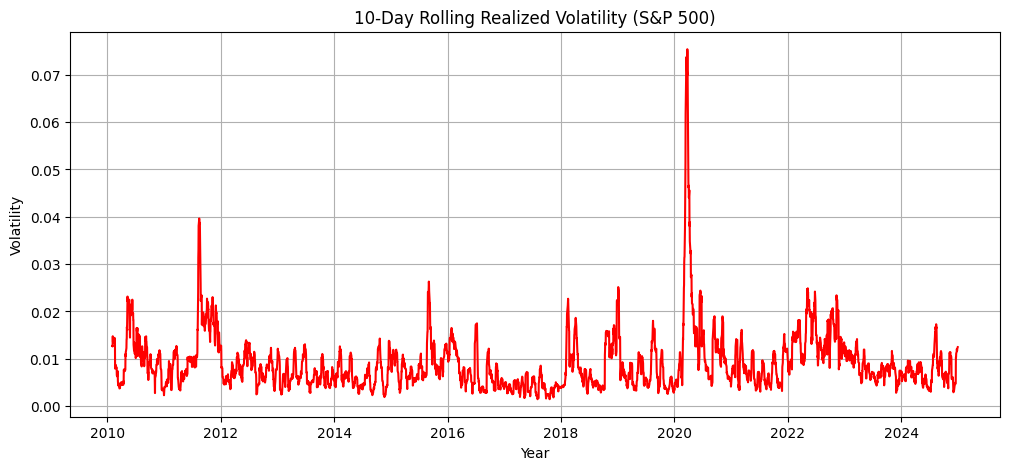

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['RealizedVolatility'], color='red')
plt.title('10-Day Rolling Realized Volatility (S&P 500)')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()


## **Price vs. Volatility Relationship**

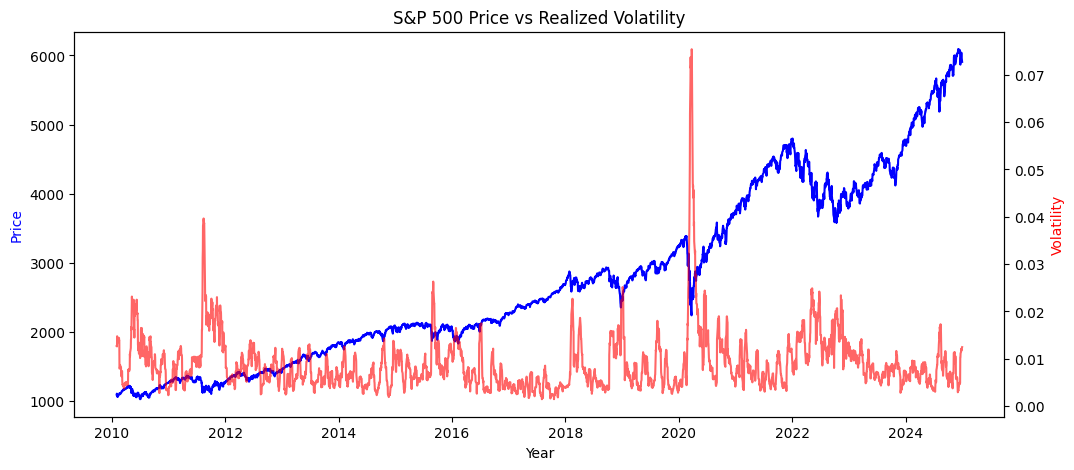

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(data.index, data['Close'], color='blue', label='Close')
ax2 = ax1.twinx()
ax2.plot(data.index, data['RealizedVolatility'], color='red', label='Volatility', alpha=0.6)
ax1.set_xlabel('Year')
ax1.set_ylabel('Price', color='blue')
ax2.set_ylabel('Volatility', color='red')
plt.title('S&P 500 Price vs Realized Volatility')
plt.show()


# **Create a binary classification label from RealizedVolatility**

In [ ]:
# Use median split (balanced) — change to quantile(0.7) for top-30%-as-high, etc.
threshold = data['RealizedVolatility'].median()
data['VolHigh'] = (data['RealizedVolatility'] >= threshold).astype(int)

features = ['LogReturn', 'MA_5', 'MA_20', 'Volume', 'Volume_MA_5']
X = data[features].copy()
y_cls = data['VolHigh'].copy()

print("Threshold used for High volatility:", threshold)
y_cls.value_counts(normalize=True).rename({0:'Low',1:'High'}).to_frame('share')


Threshold used for High volatility: 0.007523539859444759


,share
VolHigh,
High,0.5
Low,0.5


# **Train Test Split**

In [ ]:
split_idx = int(len(X) * 0.80)  # 80% train, 20% test chronologically
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y_cls.iloc[:split_idx], y_cls.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (3003, 5) Test size: (751, 5)


# **Defining the models**
1. Logistic Regression
2. SVC
3. KNN
4. Random Forest
5. GradientBoosting
6. HistGradBoost

In [ ]:
def pipe_scale(est):
    """Attach StandardScaler for models that benefit from feature scaling."""
    return Pipeline([('scaler', StandardScaler()), ('clf', est)])

models = {
    'LogisticRegression': pipe_scale(LogisticRegression(max_iter=2000, random_state=42)),
    'SVC (RBF)':         pipe_scale(SVC(kernel='rbf', probability=True, random_state=42)),
    'KNN (k=15)':        pipe_scale(KNeighborsClassifier(n_neighbors=15)),
    'RandomForest':      RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42),
    'GradientBoosting':  GradientBoostingClassifier(random_state=42),
    'HistGradBoost':     HistGradientBoostingClassifier(random_state=42)
}


# **Model Training and Calculating Evalution Metrics**

In [ ]:
results = []
roc_curves = {}  # model -> (fpr, tpr, auc)

for name, est in models.items():
    # Train timing
    t0 = time.perf_counter()
    est.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    # Inference timing
    t1 = time.perf_counter()
    y_pred = est.predict(X_test)
    if hasattr(est, "predict_proba"):
        y_score = est.predict_proba(X_test)[:, 1]
    elif hasattr(est, "decision_function"):
        y_score = est.decision_function(X_test)
    else:
        y_score = y_pred.astype(float)
    test_time = time.perf_counter() - t1

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc  = roc_auc_score(y_test, y_score)
    except ValueError:
        auc = np.nan

    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1,
        'ROC_AUC': auc, 'TrainTime_s': train_time, 'TestTime_s': test_time,
        'ConfusionMatrix': cm
    })

    # ROC curve data
    try:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_curves[name] = (fpr, tpr, auc)
    except ValueError:
        pass

# Summary table
summary_df = pd.DataFrame(results).drop(columns=['ConfusionMatrix']).sort_values('ROC_AUC', ascending=False)
print("=== Test-set performance (sorted by ROC_AUC) ===")
print(summary_df.to_string(index=False))

# Classification reports
print("\n=== Classification reports ===")
for r in results:
    name = r['Model']
    est = models[name]
    y_pred = est.predict(X_test)
    print(f"\n[{name}]")
    print(classification_report(y_test, y_pred, digits=4))


=== Test-set performance (sorted by ROC_AUC) ===
             Model  Accuracy  Precision   Recall       F1  ROC_AUC  TrainTime_s  TestTime_s
LogisticRegression  0.604527   0.948837 0.416327 0.578723 0.803769     0.044336    0.007308
        KNN (k=15)  0.593875   0.960199 0.393878 0.558611 0.771835     0.007819    0.032933
      RandomForest  0.608522   0.784884 0.551020 0.647482 0.675475     3.781943    0.542993
     HistGradBoost  0.605859   0.737745 0.614286 0.670379 0.674330     0.252727    0.031875
  GradientBoosting  0.596538   0.691207 0.689796 0.690501 0.636215     1.302337    0.005549
         SVC (RBF)  0.541944   0.679803 0.563265 0.616071 0.589323     4.635819    0.517841

=== Classification reports ===

[LogisticRegression]
              precision    recall  f1-score   support

           0     0.4664    0.9579    0.6274       261
           1     0.9488    0.4163    0.5787       490

    accuracy                         0.6045       751
   macro avg     0.7076    0.6871  

# **Combined ROC Curve**

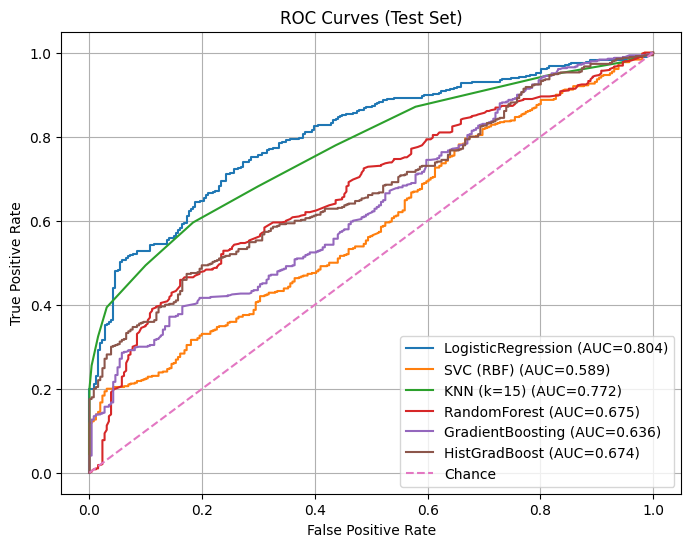

In [ ]:
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], '--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


# **Individual ROC curve for trained models**

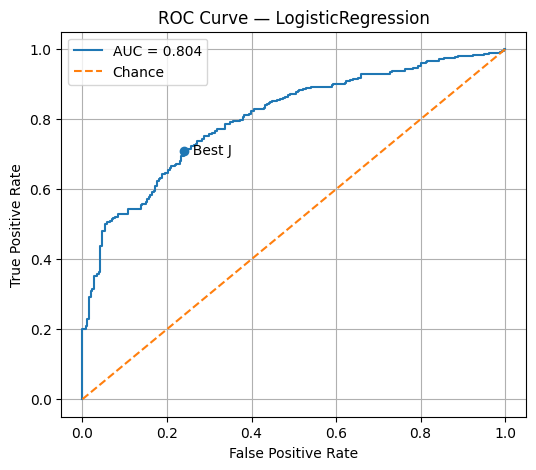

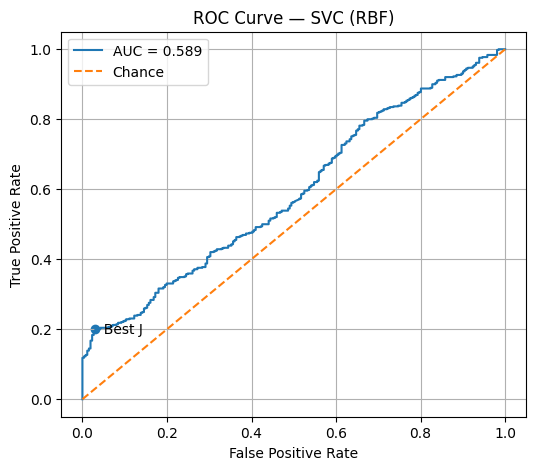

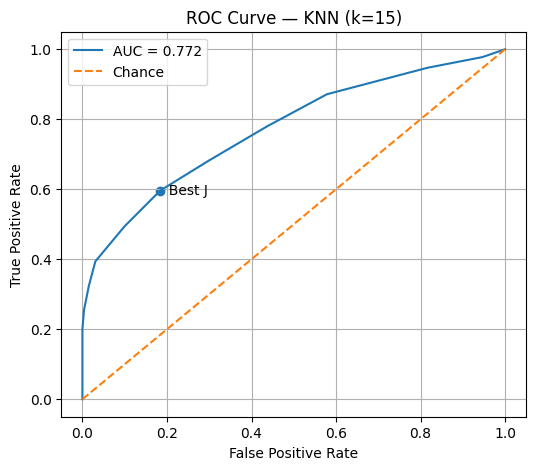

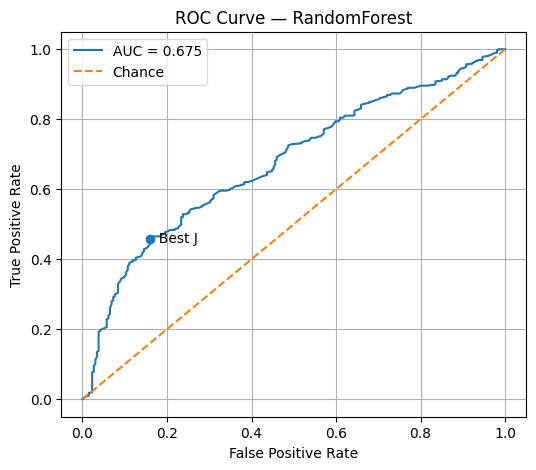

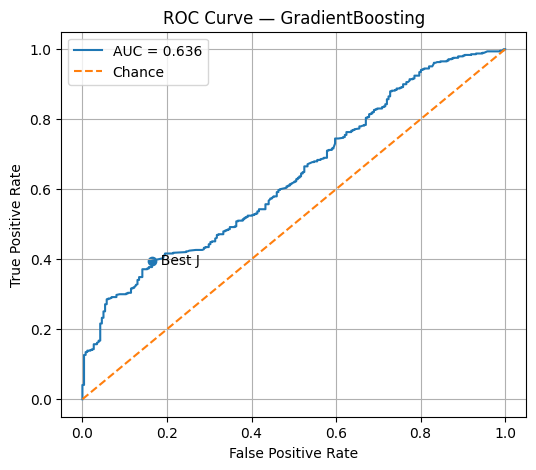

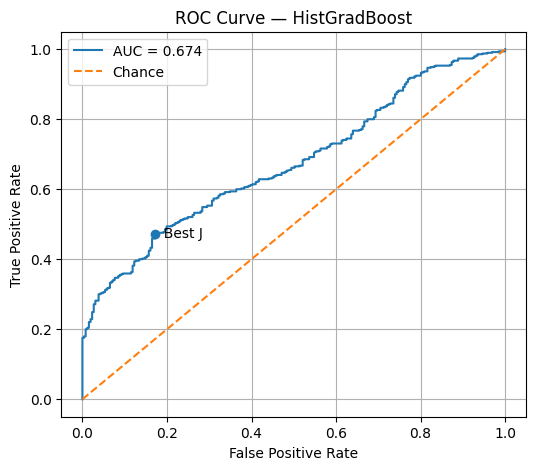

In [ ]:

def plot_individual_roc_from_cache(roc_curves_dict):
    for name, (fpr, tpr, auc) in roc_curves_dict.items():
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        plt.plot([0,1], [0,1], '--', label="Chance")
        # Mark best Youden J point (optional)
        youden_idx = np.argmax(tpr - fpr)
        plt.scatter(fpr[youden_idx], tpr[youden_idx], marker='o')
        plt.text(fpr[youden_idx], tpr[youden_idx], "  Best J", va='center')

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_individual_roc_from_cache(roc_curves)


# **Confusion Matrix for trained models**

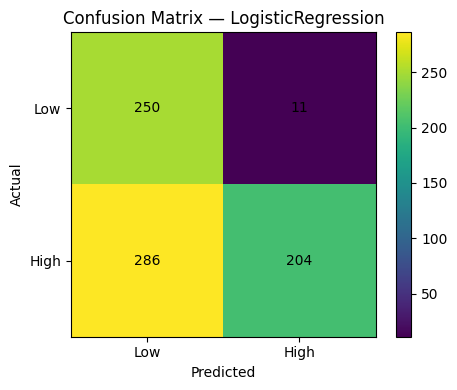

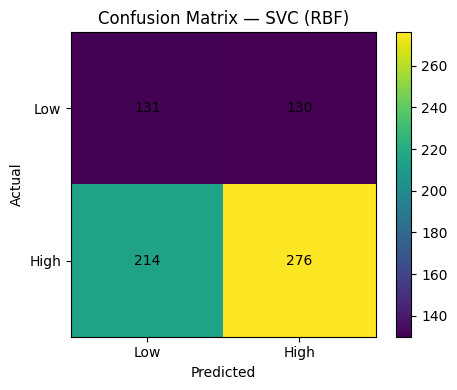

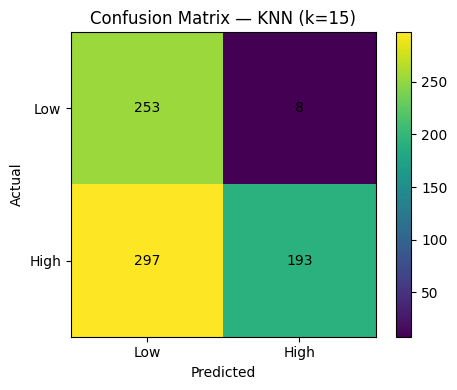

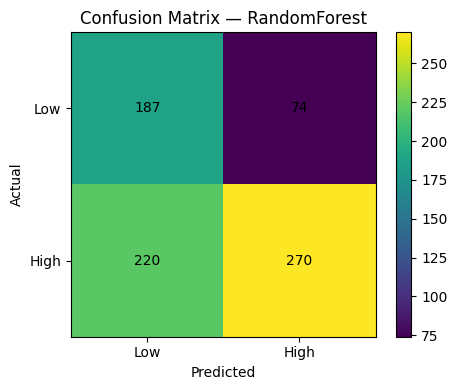

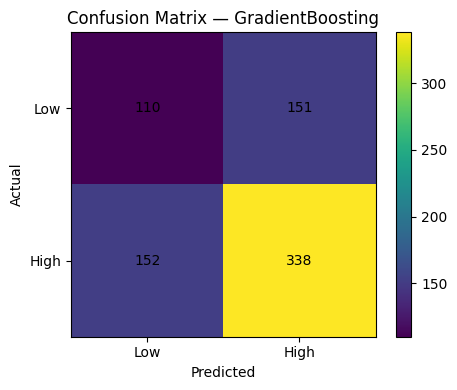

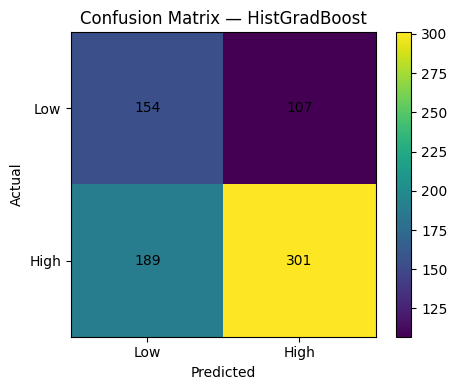

In [ ]:
def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Low', 'High']); ax.set_yticklabels(['Low', 'High'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()

for r in results:
    plot_cm(r['ConfusionMatrix'], f"Confusion Matrix — {r['Model']}")


# **5-Fold Cross Validation of all implemented models**

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
cv_rows = []

for name, est in models.items():
    used_scoring = 'roc_auc'
    try:
        scores = cross_val_score(est, X, y_cls, cv=tscv, scoring='roc_auc', n_jobs=-1)
    except Exception:
        used_scoring = 'accuracy'
        scores = cross_val_score(est, X, y_cls, cv=tscv, scoring='accuracy', n_jobs=-1)

    cv_rows.append({
        'Model': name,
        'CV_Scoring': used_scoring,
        'CV_Mean': np.mean(scores),
        'CV_Std':  np.std(scores)
    })

cv_df = pd.DataFrame(cv_rows).sort_values('CV_Mean', ascending=False)
print("\n=== 5-Fold TimeSeriesSplit CV ===")
print(cv_df.to_string(index=False))



=== 5-Fold TimeSeriesSplit CV ===
             Model CV_Scoring  CV_Mean   CV_Std
LogisticRegression    roc_auc 0.784325 0.077514
        KNN (k=15)    roc_auc 0.697948 0.093379
     HistGradBoost    roc_auc 0.685101 0.126071
      RandomForest    roc_auc 0.657270 0.135762
  GradientBoosting    roc_auc 0.631704 0.162560
         SVC (RBF)    roc_auc 0.621710 0.111474
